In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("credit_risk_dataset.csv")

Let's check our data for NaNs

In [3]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Too many NaNs in interest rate column, let's check if we could drop them

In [4]:
missing_rate = df[df['loan_int_rate'].isna()]
not_missing = df[~df['loan_int_rate'].isna()]

#comparing numeric feature values for 
compare_df = pd.DataFrame({
    'Rate is missing': missing_rate.mean(numeric_only=True),
    'Rate isn`t missing': not_missing.mean(numeric_only=True)
})
print(compare_df[['Rate is missing', 'Rate isn`t missing']])

                            Rate is missing  Rate isn`t missing
person_age                        27.922657           27.714712
person_income                  66589.048460        66020.470490
person_emp_length                  4.799213            4.788672
loan_amnt                       9633.119384         9584.744612
loan_int_rate                           NaN           11.011695
loan_status                        0.206675            0.219379
loan_percent_income                0.171088            0.170110
cb_person_cred_hist_length         5.955071            5.788257


Well, for now we can't say if these differences are significant, so let's check it using Welch's t-test

In [5]:
from scipy.stats import ttest_ind

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
results = []

for col in numeric_cols:

    group_a = missing_rate[col].dropna()
    group_b = not_missing[col].dropna()

    t_stat, p_value = ttest_ind(group_a, group_b, equal_var=False)
    mean_diff = group_a.mean() - group_b.mean()

    results.append({
        'Feature': col,
        'average diff': mean_diff,
        'p-value': p_value,
        'Significant': p_value < 0.05
    })


results_df = pd.DataFrame(results)
results_df



,Feature,average diff,p-value,Significant
0,person_age,0.207945,0.101437,False
1,person_income,568.577969,0.630144,False
2,person_emp_length,0.010540,0.891119,False
3,loan_amnt,48.374772,0.686957,False
4,loan_int_rate,NaN,NaN,False
5,loan_status,-0.012704,0.096660,False
6,loan_percent_income,0.000978,0.624219,False
7,cb_person_cred_hist_length,0.166813,0.036934,True


For at lest one feature difference is statistically significant, so we can't just drop it. Let's make a special feature of missing value instead.


In [6]:
median_rates = df.groupby('loan_grade')['loan_int_rate'].median().sort_values()
median_rates

loan_grade
A     7.490
B    10.990
C    13.480
D    15.310
E    16.820
F    18.535
G    20.160
Name: loan_int_rate, dtype: float64

Also we can see, that median_rates are different for different credit grades (it can be seen even without statistical tests), so let's fill missing values with median value of corresponding grade

In [7]:
df['loan_int_rate'] = df.groupby('loan_grade')['loan_int_rate'].transform(
    lambda x: x.fillna(x.median())
)

For employment lwength we can just use median value

In [8]:
median_value = df['person_emp_length'].median()
df['person_emp_length'].fillna(median_value, inplace=True)

Also, let's log income to avoid distortions that can happen due to people with too much income.

In [9]:
df['log_income'] = np.log(df['person_income'])

**Encoding**

Let's use ordinal encoding for credit grade

In [10]:
grade_order = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['loan_grade'] = df['loan_grade'].map(grade_order)


In [11]:
df.nunique()

person_age                      58
person_income                 4295
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      753
loan_int_rate                  349
loan_status                      2
loan_percent_income             77
cb_person_default_on_file        2
cb_person_cred_hist_length      29
log_income                    4295
dtype: int64

as we can see, for other categorical features, the number of unique values is not so large, so we can use one-hot-encoding.

In [12]:
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent'])

In [13]:
hist_order = {'Y': 1, 'N': 0}
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map(hist_order)

Now let's check for outliers

In [14]:
numeric_cols = [
    'person_age',
    'log_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]

def count_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return len(outliers)

outliers_stats = pd.DataFrame({
    'column': numeric_cols,
    'outliers_count': [count_outliers(df[col]) for col in numeric_cols],
    'percentage_outliers': [count_outliers(df[col]) / len(df) * 100 for col in numeric_cols]
})

print(outliers_stats)

                       column  outliers_count  percentage_outliers
0                  person_age            1494             4.585495
1                  log_income             578             1.774040
2           person_emp_length             853             2.618090
3                   loan_amnt            1689             5.184003
4               loan_int_rate               6             0.018416
5         loan_percent_income             651             1.998097
6  cb_person_cred_hist_length            1142             3.505110


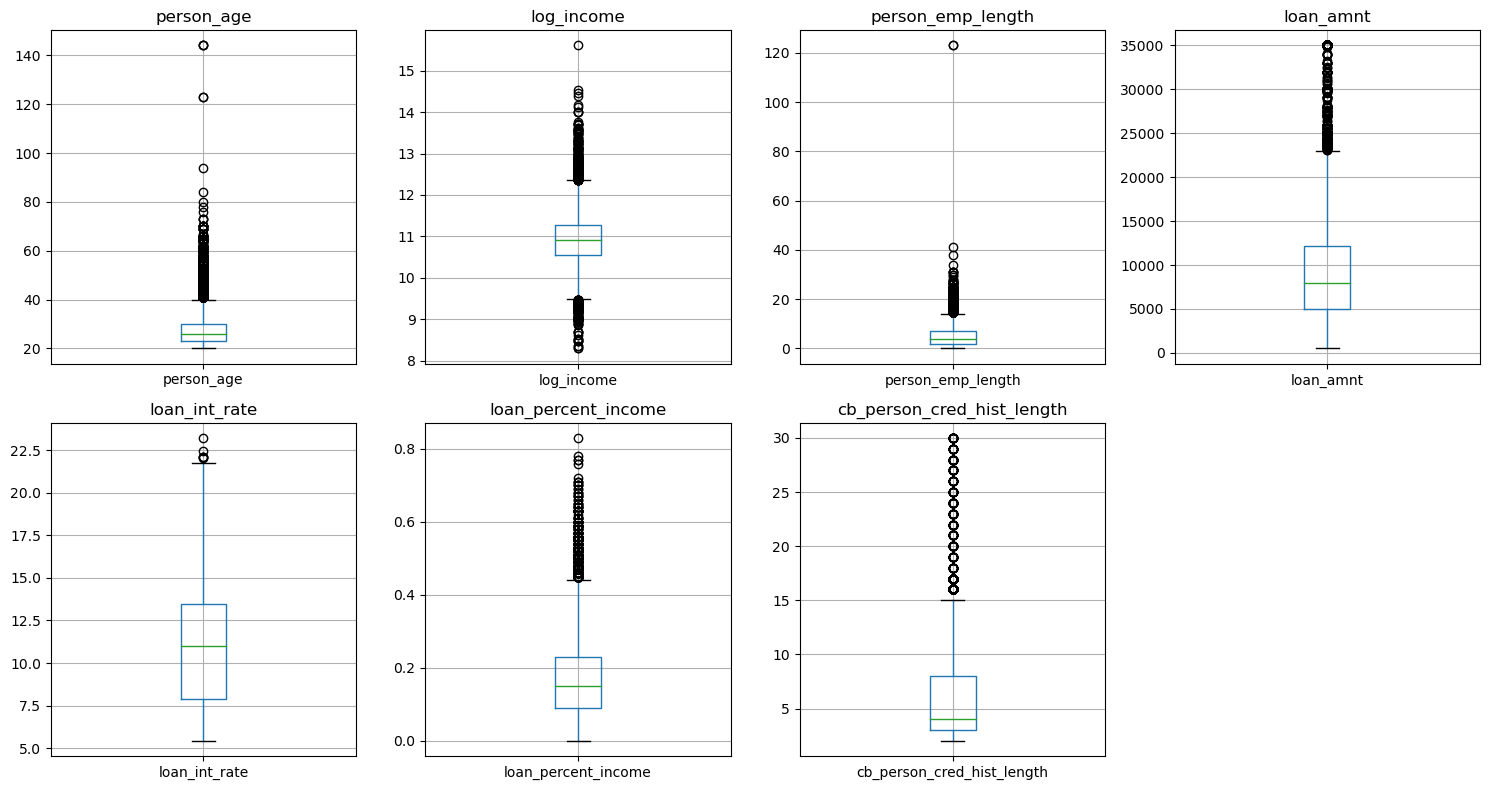

In [15]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)
    df.boxplot(column=col)
    plt.title(col)
plt.tight_layout()
plt.show()

We can see from the charts that there are clearly abnormal values for age and work experience.

In [16]:
df_clean = df.copy()

df_clean = df_clean[df_clean['person_age'] <= 100]

df_clean = df_clean[df_clean['person_emp_length'] <= (df_clean['person_age'] - 10)]

df_clean = df_clean[df_clean['cb_person_cred_hist_length'] <= (df_clean['person_age'] - 10)]


Now let's normalize our data

In [17]:
from sklearn.preprocessing import StandardScaler
df_normalized = df_clean.copy()
scaler = StandardScaler()
df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])


In [18]:
df_normalized=df_normalized.drop('person_income',axis=1)

In [20]:

df_normalized.to_csv('Untitled Folder/processed_data.csv', index=False)